In [1]:
# compare the p-values for different time periods (1970-2015 vs. 1981-2015, varying lag numbers)
# an on-the-fly OLS fitting is done, and pre-computed bootstrapped fits are compared

import matplotlib.pyplot as plt
import matplotlib.gridspec as mgridspec
import numpy as np
import scipy
import xarray as xr

import tc_cost.sourcedata.figs01 as sd_figs01
import tc_cost.util.constants as u_const
import tc_cost.util.data as u_data
import tc_cost.util.plot as u_plot
u_plot.main_setup_mpl(agg=False)

During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MONETARY failed, using "C" 
3: Setting LC_PAPER failed, using "C" 
4: Setting LC_MEASUREMENT failed, using "C" 


In [2]:
timehorizons = np.arange(0, 20)
periods = [(1970, 2015), (1981, 2015)]
temp_pred_vals = np.linspace(-3, 30.5, 100)

In [3]:
results = {}
predictions = {}
for period in periods:
    results[period] = []
    predictions[period] = []
    for timehorizon in timehorizons:
        # fit an OLS model and predict on the fly
        tc_pred_vals = np.arange(timehorizon + 1)
        ds_fitdata = sd_figs01.load_fitdata_all(timehorizon, exclude_sources=["burke", "hazem"])["gswp3-w5e5"]
        aff_cols = [v for v in ds_fitdata.data_vars if v.startswith("aff")]
        fitrd = (
            ds_fitdata
            .to_dataframe()
            .dropna(subset=["gdppc_ch", "temp", "temp2", "time"] + aff_cols, how="any")
            .reset_index()
        )
        fitrd = fitrd[
            (fitrd["year"] >= period[0])
            & (fitrd["year"] <= period[1])
        ].copy()
        res = sd_figs01.ols_fit_model(fitrd, tc_effect=True, temp=True)
        ta_predicted, ta_pred_ci = sd_figs01.predict_temp_from_ols(res, temp_pred_vals)
        tc_predicted, tc_pred_ci = sd_figs01.predict_tc_from_ols(res)
        results[period].append(res)
        predictions[period].append((
            sd_figs01.predict_temp_from_ols(res, temp_pred_vals),
            sd_figs01.predict_tc_from_ols(res),
        ))

Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from /home/tovogt/code/tc_cost/data/cache/IHME_GLOBAL_GDP_ESTIMATES_1950_2015.nc ...
Loading cached GDP per capita data from 

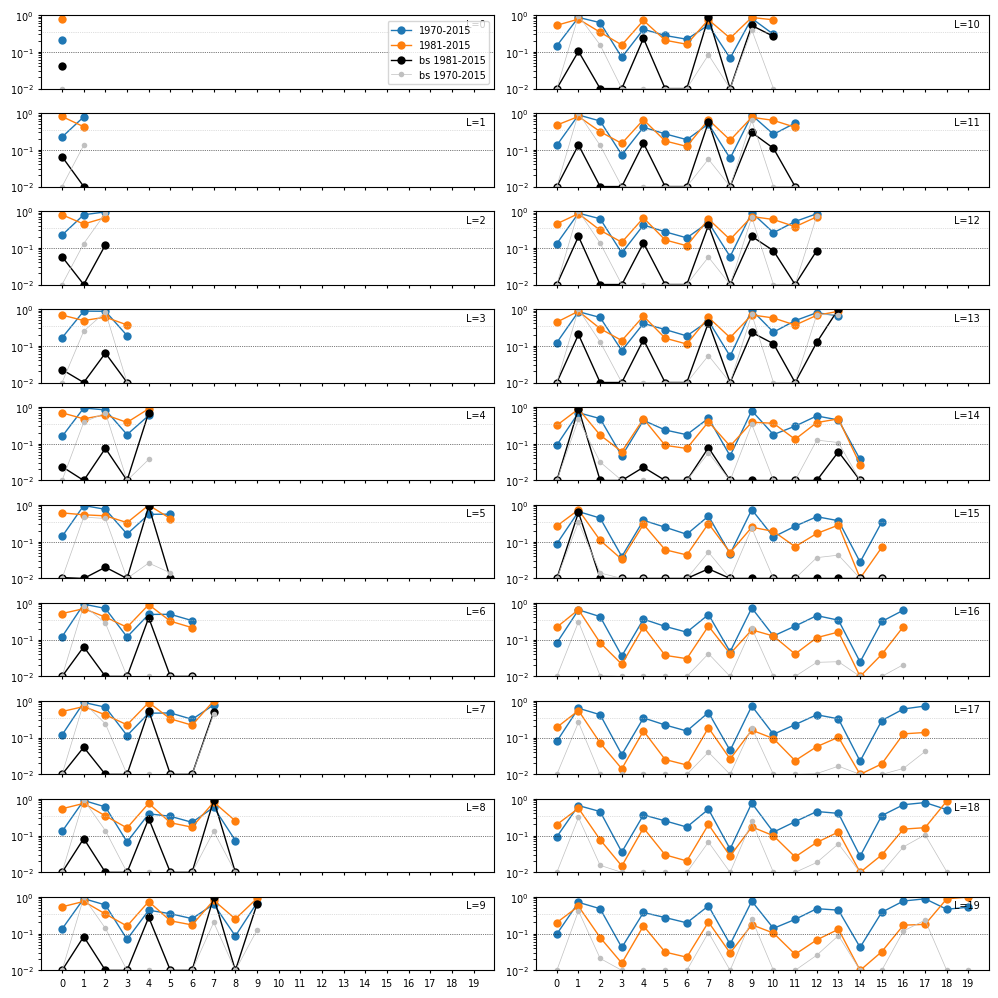

In [4]:
fig = plt.figure(figsize=(10, 10))
nrows, ncols = len(timehorizons) // 2, 2
axs = fig.subplots(nrows, ncols, sharex=True)
pv_range = (0.01, 1.0)
for i_row, timehorizon in enumerate(timehorizons):
    ax = axs[i_row % nrows, i_row // nrows]
    lags = np.arange(0, timehorizon + 1)
    aff_cols = [f"aff{l}" for l in lags]

    for i_period, (period, cl) in enumerate(zip(periods, ["tab:blue", "tab:orange"])):
        pvalues = results[period][i_row].pvalues[aff_cols].values
        ax.plot(
            lags, np.clip(pvalues, *pv_range),
            color=cl, label=f"{period[0]}-{period[1]}",
            marker="o",
        )

    for path in [
        u_const.BOOTSTRAP_DIR / "estimates" / f"coeffs_{timehorizon}_ols_temp.nc",
        u_const.BOOTSTRAP_DIR / "estimates" / f"coeffs_{timehorizon}_ols_temp_1970-2015.nc",
    ]:
        if not path.exists():
            continue
        ext_period = "1970" in path.name
        period = (1970, 2015) if ext_period else (1981, 2015)
        ds_coeffs = xr.open_dataset(path)
        coeff_est = ds_coeffs.sel(
            coeff=aff_cols,
            elt=ds_coeffs.elt != "original",
        )['Estimate']
        zvalues_bs = coeff_est.mean(dim="elt") / coeff_est.std(dim="elt")
        pvalues_bs = 2 * scipy.stats.norm.sf(np.abs(zvalues_bs))
        ax.plot(
            lags, np.clip(pvalues_bs, *pv_range),
            color="silver" if ext_period else "black",
            linewidth=0.5 if ext_period else 1,
            label=f"bs {period[0]}-{period[1]}",
            marker="o", markersize=4 if ext_period else 6,
        )

    ax.semilogy()
    ax.set_ylim(*pv_range)
    ax.axhline(0.10, linewidth=0.5, color="black", linestyle=":")
    ax.axhline(0.34, linewidth=0.5, color="silver", linestyle=":")
    ax.text(
        0.98, 0.95,
        f"L={timehorizon}",
        va="top", ha="right",
        transform=ax.transAxes,
    )
    if i_row == 0:
        ax.legend(loc="lower right")
ax.set_xticks(lags)
fig.tight_layout()